# Demo of the solarchallenge package

This file contains a demonstration of the solarchallenge. The purpose is to simulate the power generated by an orbiting solar panel. For the challenge, it is assumed that the solar photovoltaic cells are always pointing at zenith.

The package allows for performing orbit propagation with perturbation, assuming a two-body problem, computing the power generated using the Pindado-Cubas equation, and performing thermal analysis of the solar panel, using a lumped mass approach.

### Setting up an orbit

In [ ]:
from solarchallenge.constants import J2000, A_EARTH, ECC_EARTH, INC_EARTH, RAAN_EARTH, ARGP_EARTH, NU_EARTH
from solarchallenge.trajectory.orbit import Orbit
from solarchallenge.bodies.bodies import Sun, Earth
import numpy as np

An orbit can be set up using the **Orbit class.**

In [ ]:
# Setting up Earth Orbit at J2000
earth_orbit = Orbit.from_coe(a=A_EARTH, ecc=ECC_EARTH, inc=INC_EARTH, raan=RAAN_EARTH, argp=ARGP_EARTH, nu=NU_EARTH,
                             epoch=J2000,
                             attractor=Sun)          

The solution is stored in r (position) and v (velocity) vectors, in the cartesian frame.

If the attractor is the Sun, the frame of reference is EME2000, positioned at the solar system barycenter.
In this challenge, we assume the Sun's centre of mass and barycenter to be the same.

If the attractor is the Earth, the frame of reference is J2000, positioned at Earth's centre of mass

Setting the orbit of a satellite or solar panel is a similar process.
However, the frame of reference is centred on Earth (J2000 frame).

For example, to set up the ISS orbit.Orbit

In [ ]:
# Position [km]
r_iss = [859.07256, -4137.20368,  5295.56871]

# Velocity [km/s]
v_iss = [7.37289205, 2.08223573, 0.43999979]

iss_orbit = Orbit.from_vector(r=r_iss, v=v_iss, epoch=J2000, attractor=Earth)

### Orbit Propagation

In [ ]:
from solarchallenge.trajectory.propagator import propagate_cowell

The orbits are propagated using Cowell's formulation, equivalent to the sum of the Keplerian accelerations and perturbations


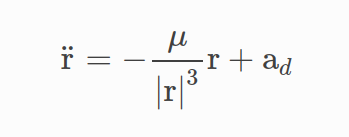

If there are no perturbations, Cowell is equivalent to a Kepler propagation.

In [ ]:
# Propagating orbit for 48 hours
from solarchallenge.constants import H

tf = (48 * H).total_seconds()

#We obtain the final position and velocity of the ISS
r_final, v_final = propagate_cowell(orbit=iss_orbit, tf=tf)

print(f"Initial position: {iss_orbit.r} -> 48 hours: Final position: {r_final}")
print(f"Initial velocity: {iss_orbit.v} -> 48 hours: Final velocity: {v_final}")

In [ ]:
# We can keep track of the propagation solution by using the t_eval argument
# The points listed in t_eval are evaluated during orbit propagation

n_points = 10000
t_eval = np.linspace(0, tf, n_points)

r_list, v_list = propagate_cowell(orbit=iss_orbit, tf=tf, t_eval=t_eval)
r_list = np.swapaxes(r_list, 0, 1)

print(r_list.shape)

In [ ]:
from solarchallenge.visualization.plotting import plot_orbit
from solarchallenge.constants import R_MEAN_EARTH

# ISS Orbit Without perturbations
plot_orbit(r_list, R_MEAN_EARTH*0.5)

We can easily set different orbits using the Orbit class

In [ ]:
orbit = Orbit.from_coe(a=R_MEAN_EARTH+5000, ecc=0.55, inc=30, raan=0, argp=154, nu=255,
                             epoch=J2000, attractor=Earth)  

r_list, v_list = propagate_cowell(orbit=orbit, tf=tf, t_eval=t_eval)
r_list = np.swapaxes(r_list, 0, 1)
plot_orbit(r_list, R_MEAN_EARTH*0.5)

To account for **perturbations**, the user has to pass the wrapper functions into propagate_cowell(), to be accessed by scipy.solve_ivp solver.

In [ ]:
from solarchallenge.constants import J2_EARTH, J3_EARTH, R_MEAN_EARTH
from solarchallenge.trajectory.perturbations import constant_accel_wrapper, J2_perturbation_wrapper, J3_perturbation_wrapper
from solarchallenge.visualization.plotting import plot_coe

#constant_accel_wrapper is a wrapper function to account for constant acceleration in the velocity direction
orbit = Orbit.from_vector(r = [-2384.46, 5729.01, 3050.46],
                          v = [-7.36138, -2.98997, 1.64354],
                          epoch = J2000,
                          attractor = Earth)

perturbations = [constant_accel_wrapper(0E-7),
                 J2_perturbation_wrapper(J2=J2_EARTH, R=R_MEAN_EARTH)]

r_list, v_list = propagate_cowell(orbit=orbit, tf=tf, t_eval=t_eval, perturbations=perturbations)
r_list = np.swapaxes(r_list, 0, 1)
v_list = np.swapaxes(v_list, 0, 1)

plot_orbit(r_list, R_MEAN_EARTH*0.5)

time = orbit.epoch.timestamp() + t_eval
plot_coe(r_list, v_list, time, orbit.attractor.mu)

### Setting the solar panel

The solar panel is set up using the class **SolarPanel**, which stores the solar panel information. This module was developed having in mind the computation of power to be as realistic as possible. For this effect, a method similar to the single diode model was integrated into this work. More information on this model can be found in https://oa.upm.es/67369/1/IEEETran_Aerospece_2021.pdf.

To initialize a SolarPanel object, we define a dictionary with the solar panel specifications, that can be easily found in solar panel data sheets.

In [ ]:
from solarchallenge.solarpanel.solarpanel import SolarPanel

panel_information = {
    'a': 1,     # ideality factor of the diode
    'n_s': 1,   # Number of series connected cells
    'i_sc': 0.506, #short circuit current
    'v_oc': 2.667, #open circuit voltage
    'i_mp': 0.487, #current at maximum power
    'v_mp': 2.371, #voltage at maximum power
    'alpha_i_sc': 0.32/1000.0, #thermal coefficients
    'alpha_v_oc': -6.0/1000.0,
    'alpha_v_mp': -6.1/1000.0,
    'alpha_i_mp': 0.28/1000.0,
    'tref': 28,  # temperature of reference
    'solar_irr_ref': 1367, #solar irradiance of reference
    'eff': 1 # Panel efficiency (To account for other losses)
}

# Only used if the thermal model is activated, but required to initialize the object
additional_panel_information = {
     "area": 1,  # Area
     "mass": 1, # Mass
     "c": 1000, # Specific heat capacity
     "emittance_back": 1.0,
     "emittance_front": 1.0,
     "absorptance_back": 1.0,
     "absorptance_front": 1.0,
}

panel = SolarPanel.from_dict(panel_information | additional_panel_information)

The power produced by the solar panel depends on external factors (solar incidence, inclination) but also on the voltage of operation and temperature of the solar panel.

In [ ]:
solar_irr = 1367   #Depends on the Sun-panel distance
angle_incidence = 0
temperature = 28 #solar panel temperature
voltage = 2 # Voltage of operation

power, __, __ = panel.compute_power(solar_irr=solar_irr, angle_incidence=angle_incidence,
                                    temperature=temperature, voltage=voltage)
print(f"Temperature = {temperature} ºC - Voltage = {voltage} V -> Produces {np.round(power,3)} W")

voltage = 3

power, __, __ = panel.compute_power(solar_irr=solar_irr, angle_incidence=angle_incidence,
                                    temperature=temperature, voltage=voltage)
print(f"Temperature = {temperature} ºC - Voltage = {voltage} V -> Produces {np.round(power,3)} W")

If the voltage = 3, the power is 0 as the solar panel voltage is above the open circuit voltage (2.667 at temperature = 28 degrees Celsius).

If no voltage is given, the solar panel is assumed to be operating at maximum power.

In [ ]:
power, __, v_mp = panel.compute_power(solar_irr=solar_irr,
                                      angle_incidence=angle_incidence,
                                      temperature=temperature)

print(f"Maximum power for temperature = {temperature} ºC")
print(f"Temperature = {temperature} ºC - Voltage = {v_mp} V -> Produces {np.round(power,3)} W")

In [ ]:
from solarchallenge.visualization.plotting import plot_IV
# Print of the IV plots

print("IV plots depending on temperature")
plot_IV(panel=panel, solar_irr=1367, temperature = np.array([20,40,60,80]))

print("IV plots depending on effective solar irradiance")
plot_IV(panel=panel, solar_irr=np.array([200, 600, 1000, 1367]), temperature = 28)


As shown by the IV plots, the power produced by the solar panel depends on the temperature. To compute the temperature of the solar panel, a lumped mass approach was introduced to perform thermal analysis.

### Model class -  Propagating the orbit for a specific date interval.

The solarchallenge package has the class **Model**, used to store the propagation, power and temperature information, but also to be used as the driver of the solar panel simulation.

In [ ]:
from solarchallenge.model import Model
from solarchallenge.constants import J2000, D

#Create a new object of type Model
simulator = Model()

#Define orbits
orbit = Orbit.from_vector(r = [-2384.46, 5729.01, 3050.46],
                          v = [-7.36138, -2.98997, 1.64354],
                          epoch = J2000,
                          attractor = Earth)

earth_orbit = Orbit.from_coe(a=A_EARTH, ecc=ECC_EARTH, inc=INC_EARTH, raan=RAAN_EARTH, argp=ARGP_EARTH, nu=NU_EARTH,
                             epoch=J2000,
                             attractor=Sun)

#Specify the orbits used in the simulation
simulator.set_orbit_body(earth_orbit)
simulator.set_orbit_solar_panel(orbit)

#Propagate the orbit for a given interval
simulator.propagate_orbit(start=J2000 + 28 * D, # The datetime for start argument needs to be later than the epochs of the orbits
                          end=J2000 + 29 * D,
                          npoints=10000, 
                          perturbations_panel = None,
                          perturbations_planet = None)

plot_orbit(simulator.r_panel, R_MEAN_EARTH * 0.5)
plot_coe(simulator.r_panel, simulator.v_panel, simulator.time, simulator.orbit_panel.attractor.mu)

Using the propagate_orbit() function, the orbits are propagated until the specified end time.
The solution between the start time and end time is stored using an array size of npoints evenly distributed in time.

The propagation of the solar panel and planet starts at the orbit state epoch. After propagation, the position and velocity state vectors of both solar panel and planet are stored.

### Model class - Computing power for propagated trajectory

After orbit propagation, the power provided by the solar panel can be computed.

For the challenge, we assume the solar panel to always be pointing to zenith. Therefore, all the required angles can be retrieved from the position of the planet with respect to the Sun, and the position of the solar panel with respect to Earth.

The solar irradiance is retrieved as a function of the distance between the sun and the solar panel.

In [ ]:
from solarchallenge.visualization.plotting import plot_power
from solarchallenge.solarpanel.utils import compute_solar_radiance, compute_angle_solar_incidence

#Set solar panel characteristics
simulator.set_solar_panel(panel)

#Compute power for interval of time
# If maximum_power is set to False, the power computation is perfomed using the defined voltage of operation
simulator.compute_power(temperature=28, voltage=2, maximum_power=False)

#Plot power and effective irradiance
solar_irr = compute_solar_radiance(simulator.r_planet, simulator.r_panel)
theta = compute_angle_solar_incidence(simulator.r_planet, simulator.r_panel)

plot_power(time=simulator.time, power=simulator.power, solar_irr=solar_irr, theta=theta)

In [ ]:
# To use the maximum power voltage, we can set the maximum_power=True
# It ignores the value of the voltage argument

#Compute power for interval of time
simulator.compute_power(temperature=28, voltage=2, maximum_power=True)

#Plot power and effective irradiance
solar_irr = compute_solar_radiance(simulator.r_planet, simulator.r_panel)
theta = compute_angle_solar_incidence(simulator.r_planet, simulator.r_panel)

plot_power(time=simulator.time, power=simulator.power, solar_irr=solar_irr, theta=theta)

### Model class - Thermal analysis and power computation

The power computation is dependent on the temperature of the solar panel. Thus, a thermal analysis can be performed by the package, assuming a lumped mass approach. In this approach, the heat conduction inside the temperature is assumed to be instantaneous, i.e. the temperature is uniformly distributed.

The evolution of temperature with respect to time depends on the area, absorptance and emittance of the solar panel surfaces, mass and specific heat capacity of the panel structure, and the heat exchange between the and space.



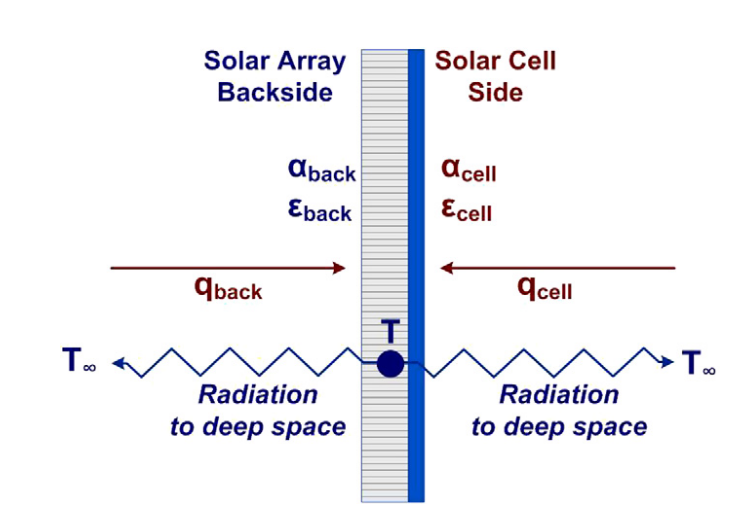
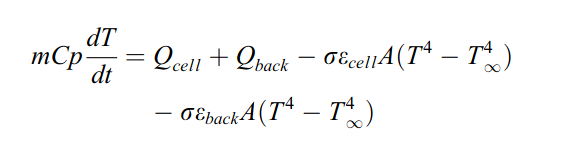

The radiation from deep space impacting the solar panel are the solar irradiance, Earth albedo and Earth emitted Infrared. 

The satellite releases energy through electric production (power) and black-body radiation (Stefan-Boltzmann)

In [ ]:
from solarchallenge.visualization.plotting import plot_temperature, plot_heat

# To perform thermal analysis, we set the thermal_model boolean to True
# If it's set to True, the temperature argument is ignored

#The thermal analysis is performed as.
# 1) Determination of the steady state solution to retrieve initial temperature (q_in = q_out)
# 2) Forward Euler method to compute Temperature using the orbit propagation time

simulator.compute_power(temperature=28, voltage=2, maximum_power=True, thermal_model=True)

plot_temperature(time=simulator.time, temperature=simulator.temperature)
plot_heat(time=simulator.time, q_earth_ir=simulator.q_earth_ir, q_earth_alb=simulator.q_earth_alb,
          q_solar_front=simulator.q_solar_front, q_solar_back=simulator.q_solar_back,
          q_sat_rad=simulator.q_sat_rad)
plot_power(time=simulator.time, power=simulator.power, solar_irr=solar_irr, theta=theta)

# Putting all together - code example

In [ ]:
from solarchallenge.solarpanel.solarpanel import SolarPanel
from solarchallenge.visualization.plotting import plot_temperature, plot_heat, plot_power, plot_orbit, plot_coe
from solarchallenge.model import Model
from solarchallenge.constants import (J2_EARTH, J3_EARTH, R_MEAN_EARTH, J2000,
                                      A_EARTH, ECC_EARTH, INC_EARTH, RAAN_EARTH,
                                      ARGP_EARTH, NU_EARTH)
from solarchallenge.trajectory.orbit import Orbit
from solarchallenge.trajectory.perturbations import constant_accel_wrapper, J2_perturbation_wrapper, J3_perturbation_wrapper
from solarchallenge.bodies.bodies import Sun, Earth

### Setting orbits

panel_orbit = Orbit.from_vector(r = [-2384.46, 4729.01, 3050.46],
                          v = [-7.36138, -2.98997, 1.64354],
                          epoch = J2000,
                          attractor = Earth)

panel_perturbations = [constant_accel_wrapper(1E-6),
                 J2_perturbation_wrapper(J2=J2_EARTH, R=R_MEAN_EARTH)]

earth_orbit = Orbit.from_coe(a=A_EARTH, ecc=ECC_EARTH, inc=INC_EARTH, raan=RAAN_EARTH, argp=ARGP_EARTH, nu=NU_EARTH,
                             epoch=J2000,
                             attractor=Sun)

earth_perturbations = []

### Setting solar panel

panel_information = {
    'a': 1,     # ideality factor of the diode
    'n_s': 1,   # Number of series connected cells
    'i_sc': 0.506, #short circuit current
    'v_oc': 2.667, #open circuit voltage
    'i_mp': 0.487, #current at maximum power
    'v_mp': 2.371, #voltage at maximum power
    'alpha_i_sc': 0.32/1000.0, #thermal coefficients
    'alpha_v_oc': -6.0/1000.0,
    'alpha_v_mp': -6.1/1000.0,
    'alpha_i_mp': 0.28/1000.0,
    'tref': 28,  # temperature of reference
    'solar_irr_ref': 1367, #solar irradiance of reference
    'eff': 1 # Panel efficiency (To account for other losses)
}

# Only used if the thermal model is activated, but required to initialize the object
additional_panel_information = {
     "area": 1,  # Area
     "mass": 1, # Mass
     "c": 1000, # Specific heat capacity
     "emittance_back": 1.0,
     "emittance_front": 1.0,
     "absorptance_back": 1.0,
     "absorptance_front": 1.0,
}

panel = SolarPanel.from_dict(panel_information | additional_panel_information)

### Simulation driver
simulator = Model()

simulator.set_orbit_body(earth_orbit)
simulator.set_orbit_solar_panel(panel_orbit)
simulator.set_solar_panel(panel)

#Propagate the orbit for a given interval
simulator.propagate_orbit(start=J2000 + 28 * D, # The datetime for start argument needs to be later than the epochs of the orbits
                          end=J2000 + 29 * D,
                          npoints=10000, 
                          perturbations_panel = panel_perturbations,
                          perturbations_planet = earth_perturbations)

#Compute power
simulator.compute_power(temperature=28, voltage=2, maximum_power=True, thermal_model=True)

### Plots
plot_orbit(simulator.r_panel, R_MEAN_EARTH * 0.5)

plot_coe(simulator.r_panel, simulator.v_panel, simulator.time, simulator.orbit_panel.attractor.mu)

plot_temperature(time=simulator.time, temperature=simulator.temperature)

plot_heat(time=simulator.time, q_earth_ir=simulator.q_earth_ir, q_earth_alb=simulator.q_earth_alb,
          q_solar_front=simulator.q_solar_front, q_solar_back=simulator.q_solar_back,
          q_sat_rad=simulator.q_sat_rad)

solar_irr = compute_solar_radiance(simulator.r_planet, simulator.r_panel)
theta = compute_angle_solar_incidence(simulator.r_planet, simulator.r_panel)
plot_power(time=simulator.time, power=simulator.power, solar_irr=solar_irr, theta=theta)